In [2]:
from gluoncv.data import VOCDetection
from  mxnet import gluon

train_dataset = VOCDetection(splits=[(2007, 'trainval'), (2012, 'trainval')])
val_dataset = VOCDetection(splits=[(2007, 'test')])
print("training images: ", len(train_dataset))
print("val images: ", len(val_dataset))


training images:  16551
val images:  4952


In [5]:
# data transform
train_image, train_label = train_dataset[6]
bboxes = train_label[:, :4]
cls = train_label[:, 4:5]
print("bboxes: ", bboxes)
print("cls: ", cls)


bboxes:  [[230.  87. 482. 255.]
 [ 10. 112. 265. 258.]]
cls:  [[7.]
 [7.]]


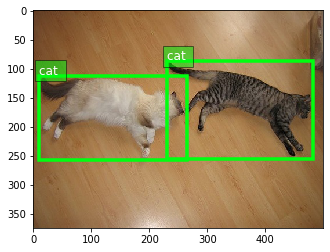

In [6]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz
ax = viz.plot_bbox(train_image.asnumpy(), bboxes, labels=cls, class_names=train_dataset.classes)
plt.show()


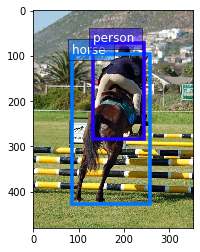

((480, 354, 3), array([[ 86.,  96., 257., 426.,  12.,   0.],
        [132.,  71., 244., 283.,  14.,   0.]]))

In [11]:
val_image, val_label = val_dataset[6]
bboxes = val_label[:, :4]
cls = val_label[:, 4:5]
ax = viz.plot_bbox(val_image.asnumpy(), bboxes, labels=cls, class_names=val_dataset.classes)
plt.show()
val_image.shape, val_label  # val_image: [0, 255]之间, (h, w, 3)


In [3]:
from gluoncv.data.transforms import presets
from mxnet import nd
short, max_size = 600, 1000
train_transform = presets.rcnn.FasterRCNNDefaultTrainTransform(short=short, max_size=max_size)
val_transform = presets.rcnn.FasterRCNNDefaultValTransform(short=short, max_size=max_size)
train_image2, train_label2 = train_transform(train_image, train_label)
print("img shape: ", train_image2.shape)  # img shape:  (3, 600, 800)
print("label shape: ", train_label2.shape)  # label shape:  (2, 6)
train_image2 = train_image2.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
train_image2 = (train_image2 * 255 ).asnumpy().astype('uint8')
ax = viz.plot_bbox(train_image2, train_label2[:, :4], labels=train_label2[:, 4:5], class_names=train_dataset.classes)
plt.show()


NameError: name 'train_image' is not defined

In [4]:
# data loader 
from gluoncv.data.batchify import  Tuple, Append
from mxnet.gluon.data import DataLoader
batch_size = 2
batchify_fn = Tuple(Append(), Append())
train_loader = DataLoader(train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover')
val_loader = DataLoader(val_dataset.transform(val_transform), batch_size, shuffle=False,
                        batchify_fn=batchify_fn, last_batch='keep')

for i, batch in enumerate(train_loader):
    if i >3:
        break
    print("data 0: ", batch[0][0].shape, " label 0: ", batch[1][0].shape)
    print("data 1: ", batch[0][1].shape, " label 1: ", batch[1][1].shape)


data 0:  (1, 3, 831, 600)  label 0:  (1, 2, 6)
data 1:  (1, 3, 600, 901)  label 1:  (1, 1, 6)
data 0:  (1, 3, 600, 800)  label 0:  (1, 4, 6)
data 1:  (1, 3, 600, 775)  label 1:  (1, 6, 6)
data 0:  (1, 3, 600, 800)  label 0:  (1, 5, 6)
data 1:  (1, 3, 750, 600)  label 1:  (1, 1, 6)
data 0:  (1, 3, 600, 898)  label 0:  (1, 1, 6)
data 1:  (1, 3, 600, 901)  label 1:  (1, 2, 6)


In [7]:
# test val_loader2
import mxnet as mx
def split_and_load(batch, ctx_list):
    """split data to 1 batch each device 什么意思？_？"""
    new_batch = []
    for i, data in enumerate(batch):
        new_data = [x.as_in_context(ctx) for x, ctx in zip(data, ctx_list)]
        new_batch.append(new_data)
    return new_batch
val_batchify_fn = Tuple(*[Append() for _ in range(3)])
val_loader2 = gluon.data.DataLoader(val_dataset.transform(val_transform), batch_size, shuffle=False,
                            batchify_fn=val_batchify_fn, last_batch='keep')
for i, batch in enumerate(val_loader2):
    if i >3:
        break
    batch = split_and_load(batch, ctx_list=mx.gpu())
    for i, data in enumerate(batch):
        pass
    print("a data in batch shape: ", len(batch[0]))
    print("data 0: ", batch[0][0].shape, " label 0: ", batch[1][0].shape)
    print("data 1: ", batch[0][1].shape, " label 1: ", batch[1][1].shape)



TypeError: zip argument #2 must support iteration

In [27]:
from gluoncv.model_zoo import get_model
net = get_model("faster_rcnn_resnet50_v1b_voc", pretrained = False)


In [32]:
import mxnet as mx
from mxnet import autograd, nd
x = mx.nd.zeros((1, 3, 600, 600))
net.initialize(force_reinit=True)
cids, scores, bboxes = net(x)
print("cids : ", cids.shape, "\nscores: ", scores.shape, "\nbboxes: ", bboxes.shape)

with autograd.train_mode():
    gt_box = nd.zeros((1, 1, 4))
    cls_preds, box_preds, roi, samples, matches, rpn_score, rpn_box, anchors = net(x, gt_box)

print("\ncls_preds: ", cls_preds.shape, "\nbox_preds: ", box_preds.shape, "\nroi: ", roi.shape, 
      "\nsamples: ", samples.shape, "\nmatches: ", matches.shape, "\nrpn_score: ", rpn_score.shape, 
      "\nrpn_box: ", rpn_box.shape, "\nanchors: ", anchors.shape)
   


cids :  (1, 6000, 1) 
scores:  (1, 6000, 1) 
bboxes:  (1, 6000, 4)

cls_preds:  (1, 128, 21) 
box_preds:  (1, 128, 20, 4) 
roi:  (1, 128, 4) 
samples:  (1, 128) 
matches:  (1, 128) 
rpn_score:  (1, 21660, 1) 
rpn_box:  (1, 21660, 4) 
anchors:  (1, 21660, 4)


'\ncls_preds:  (1, 128, 21) \nbox_preds:  (1, 128, 20, 4) \nroi:  (1, 128, 4) \nsamples:  (1, 128) \nmatches:  (1, 21660, 1) \nrpn_box:  (1, 21660, 4) \nanchors:  (1, 21660, 4)\n'

In [33]:
# training losses
rpn_cls_loss = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
rpn_box_loss = mx.gluon.loss.HuberLoss(rho=1/9.)
rcnn_cls_loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()
rcnn_box_loss = mx.gluon.loss.HuberLoss()


In [66]:
# rpn training targets
train_transform = presets.rcnn.FasterRCNNDefaultTrainTransform(short, max_size, net)
# return images, labels, rpn_cls_targets, rpn_box_targets, rpn_box_masks
batchify_fn = Tuple(*[Append() for _ in range(5)])
batch_size = 1
train_loader = DataLoader(train_dataset.transform(train_transform), batch_size, shuffle=True, 
                          batchify_fn=batchify_fn, last_batch='rollover')

for i, batch in enumerate(train_loader):
    if i > 0:
        break
    with autograd.train_mode():
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            print("data: ", data.shape)
            print("label: ", label.shape)
            print("gt box: ", gt_box.shape)
            print("gt label: ", gt_label.shape)
            print("rpn cls label:", rpn_cls_targets.shape)
            print("rpn box label: ", rpn_box_targets.shape)
            print("rpn box mask: ", rpn_box_masks.shape)


data:  (1, 3, 600, 800)
label:  (1, 10, 6)
gt box:  (1, 10, 4)
gt label:  (1, 10, 1)
rpn cls label: (1, 28500)
rpn box label:  (1, 28500, 4)
rpn box mask:  (1, 28500, 4)


In [63]:
# rcnn training targets
for i, batch in enumerate(train_loader):
    if i > 0:
        break
    with autograd.train_mode():
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            cls_preds, box_preds, roi, samples, matches, rpn_score, rpn_box, anchors = net(data, gt_box)
            cls_targets, box_targets, box_masks = net.target_generator(roi, samples, matches, gt_label, gt_box)
            print("data: ", data.shape)
            print("box: ", gt_box.shape)
            print("label: ", gt_label.shape)
            print("rcnn cls label:", cls_targets.shape)
            print("rcnn box label: ", box_targets.shape)
            print("rcnn box mask: ", box_masks.shape)
 

data:  (1, 3, 800, 600)
box:  (1, 3, 4)
label:  (1, 3, 1)
rcnn cls label: (1, 128)
rcnn box label:  (1, 128, 20, 4)
rcnn box mask:  (1, 128, 20, 4)


In [64]:
# training loop
for i, batch in enumerate(train_loader):
    if i > 0:
        break
    with autograd.record():
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            cls_preds, box_preds, roi, samples, matches, rpn_score, rpn_box, anchors = net(data, gt_box)
            cls_targets, box_targets, box_masks = net.target_generator(roi, samples, matches, gt_label, gt_box)
            
            # loss of rpn
            rpn_score = rpn_score.squeeze(axis = -1)
            num_rpn_pos = (rpn_cls_targets >= 0).sum()
            rpn_loss_cls = rpn_cls_loss(rpn_score, rpn_cls_targets, rpn_cls_targets >= 0) * rpn_cls_targets.size / num_rpn_pos
            rpn_loss_box = rpn_box_loss(rpn_box, rpn_box_targets, rpn_box_masks) * rpn_box_targets.size / num_rpn_pos
            # loss of rcnn
            num_rcnn_pos = (cls_targets >= 0).sum()
            rcnn_loss_cls = rcnn_cls_loss(cls_preds, cls_targets, cls_targets >= 0) * cls_targets.size / cls_targets.shape[0] / num_rcnn_pos
            rcnn_loss_box = rcnn_box_loss(box_preds, box_targets, box_masks) * box_targets.size / box_targets.shape[0] / num_rcnn_pos

            print("rpn cls label:", rpn_cls_targets.shape)
            
            print('rpn box: ', rpn_box.shape)
            print("rpn box label: ", rpn_box_targets.shape)
            
            print("rpn box mask: ", rpn_box_masks.shape)
            
            print("cls preds: ", cls_preds.shape)
            print("rcnn cls label:", cls_targets.shape)
            
            print("box_preds:", box_preds.shape)
            print("rcnn box label: ", box_targets.shape)
            
            print("rcnn box mask: ", box_masks.shape)
            
            print("rpn_loss_cls: ", rpn_loss_cls)
            print("rpn_loss_box: ", rpn_loss_box)
            print("rcnn_loss_cls: ", rcnn_loss_cls)
            print("rcnn_loss_box: ", rcnn_loss_box)
            



rpn cls label: (1, 28500)
rpn box:  (1, 28500, 4)
rpn box label:  (1, 28500, 4)
rpn box mask:  (1, 28500, 4)
cls preds:  (1, 128, 21)
rcnn cls label: (1, 128)
box_preds: (1, 128, 20, 4)
rcnn box label:  (1, 128, 20, 4)
rcnn box mask:  (1, 128, 20, 4)
rpn_loss_cls:  
[0.6953614]
<NDArray 1 @cpu(0)>
rpn_loss_box:  
[0.01487325]
<NDArray 1 @cpu(0)>
rcnn_loss_cls:  
[3.4416683]
<NDArray 1 @cpu(0)>
rcnn_loss_box:  
[0.13420248]
<NDArray 1 @cpu(0)>
